In [1]:
%load_ext autoreload
%autoreload 2

# Bayesian Neural Networks

We can proceed with bayesian neural networks. Their main advantages are two:
- we can measure uncertainty about our predictions with a different confidence level
- we can encode prior knowledge about weights distribution (in principle, it is harder than it sounds)

## Bayesian approach

Recall, that for normal neural networks, we used a maximum likelihood estimation of parameters that would maximize the probability of producing the data under these parameters:

$$
\text{arg max}_\theta p(\mathcal{D}|\theta)
$$

However, this formulation leads to obtaining point estimates of parameters. In short, it means no uncertainty measure. Fortunately, we can use Bayes theorem to derive equations necessary to learn distribution of parameters:

$$
p(\theta | \mathcal{D}) = \frac{p(\mathcal{D}|\theta)p(\theta)}{p(\mathcal{D})}
$$

This is our posterior distribution of parameters, and $p(\theta)$ is our prior belief about these parameters. Using bayesian inference, we can obtain predictions by integrating over all parameters $\theta$ 


$$
p(y | x, \mathcal{D}) = \int p(y | x, \theta) p(\theta | \mathcal{D})\, d\theta
$$

As you can see, these equations are intractable since there is an infinite number of configurations of parameters, and we do not know the distribution of the data.

We already know a few algorithms that can deal with, for example, Monte Carlo estimation (see [Practical Variational Inference for Neural Networks](https://papers.nips.cc/paper/4329-practical-variational-inference-for-neural-networks.pdf)). The article was published in 2011. In 2014, [Stochastic Variational Inference](http://jmlr.org/papers/v14/hoffman13a.html) was introduced, and we will look deep into this idea. You already used stochastic variational inference algorithms during previous tasks, but treated it as a black box. Its power comes from introducing variational distributions, that can be parameterized with learnable parameters (through the reparametrization trick).

## Variational inference

We start with calculation of the posterior distribution of parameters $p(\theta|\mathcal{D})$. We do not know it, and we are unable to calculate the necessary $p(\mathcal{D})$. However, we can introduce an already known concept of a variational distribution. Such a distribution is a simple approximation of a complex distribution that we do not know. We will consider gaussian variational distribution which we will denote as:

$$
q_\phi(\theta | \mathcal{D}) \approx p(\theta | \mathcal{D})
$$

$\phi$ are parameters of the variational distribution. Now, we can measure how far our approximate distribution is from the true posterior distribution using Kullback-Leibler divergence between $p$ and $q$. We search for optimal parameters of the variational distribution that minimize the KL divergence:

$$
\phi_{opt} = \text{arg min}_\phi \text{KL}\left[q_\phi(\theta | \mathcal{D}) || p(\theta|\mathcal{D}) \right]
$$

Minimizing this quantity can also be visualized:

![minimizing kl](https://miro.medium.com/max/1400/1*40KNMV9I4090DSTJ4O0oBg.gif)

The KL divergence is described as:

$$
\text{KL}\left[q_\phi(\theta | \mathcal{D})||p(\theta | \mathcal{D}) \right] = \int q_\phi(\theta| \mathcal{D}) \log\frac{q_\phi(\theta | \mathcal{D})}{p(\theta|\mathcal{D})}\, d\theta
$$

Unfortunately, there is yet another integral that causes intractability of calculations. On the other, we can handle it in a batch manner. It means that we sample weights once (so we do not have to integrate over all possible configurations) and calculate the KL for a batch of data.

We can also perform monte carlo estimation by running multiple samplings of weights. This will lead to an unbiased estimator of weights. Summarizing, finding optimal weights can be described as:

$$
\phi_{opt} = \text{arg min}_\phi \sum^n_{i=1} \log q_\phi(\theta^{(i)} | \mathcal{D}) - \log p(\theta^{(i)}) - \log p(\mathcal{D}|\theta^{(i)})
$$

where $n$ are $n$ monte carlo samples and $\theta^{(i)}$ are sampled from $q_\phi(\theta|\mathcal{D})$. Notice, that the last term is our likelihood estimate from a standard neural networks.

## Reparametrization trick

The variational parameterization above is convenient; however it lacks differentiability that is required in neural networks. Therefore, we introduce reparametrization trick that can be easily incorporated in bayesian neural networks with a gaussian parametrization (refer to [Variational Dropout and the Local Reparameterization Trick](https://arxiv.org/abs/1506.02557) for more information). In such a framework, each learnable parameter consists of two parameters: the mean and variance of a gaussian.

$$
\phi = (\mu, \sigma^2)
$$

We apply it then to reparametrization framework:

$$
f(\epsilon) = \theta = \mu + \sigma \cdot \epsilon
$$

where:

$$
\epsilon \sim \mathcal{N}(0, 1)
$$

The only nondifferentiable part is $\epsilon$, but we can care in fact about $\mu$ and $\sigma$. Thus, we can derive gradients as (note that these are automatically derived in the autograd framework):

$$
\begin{align}
    \Delta_\mu &= \frac{\partial f}{\partial \theta} + \frac{\partial f}{\partial \mu} \\
    \Delta_\sigma &= \frac{\partial f}{\partial \theta} \frac{\epsilon}{\sigma} + \frac{\partial f}{\partial \sigma}
\end{align}
$$

And update as:

$$
\begin{align}
    \mu^{(t+1)} &= \mu^{t} - \alpha \Delta_\mu \\
    \sigma^{(t+1)} &= \sigma^t - \alpha \Delta_\sigma
\end{align}
$$

This framework is called _Bayes by Backprop_ and is a core component to introduce bayesian neural networks.

## Implementing bayesian neural networks

You will work in the same setting as in the previous notebook. This includes the MNIST dataset and performed analysis. Your task is as follows:
- Implement bayesian linear layer that uses the reparametrization trick
- Implement calculation of log prob weights according to both prior and variational posterior
- Implement initialization that uses 2 gaussians, according to the linked paper
- Implement optimizing according to ELBO with $N$ samples ($N$ is an arbitrary positive number, that you can play with)

### Activation functions and Bayesian feed forward layers

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from src.nn import OwnSigmoid, OwnSoftmax, MSELoss

In [3]:
# implementing custom bayesian linear layer and sigmoid activation function
PI = 0.5
SIGMA_1 = torch.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.FloatTensor([math.exp(-6)])
class BayesianLinear(nn.Module):   # subclassing nn.Module, definition of our own bayesian fully connected layer
    """Main reference: https://arxiv.org/pdf/1505.05424.pdf"""
    def __init__(
        self, 
        num_input_features: int,  # number of input features
        num_output_features: int,  # number of output features
        use_bias: bool  # whether to use bias
    ):
        """Implement initialization of weights and biases parameters values.
        
        
        Include parameters of the prior as described in the section 3.3 of https://arxiv.org/pdf/1505.05424.pdf.
        """
        super().__init__()
        self.num_input_features = num_input_features
        self.num_output_features = num_output_features
        #Bias
        self.use_bias = use_bias
        if self.use_bias:
            self.bias_mu = nn.Parameter(torch.Tensor(self.num_output_features).uniform_(-0.2, 0.2))
            self.bias_rho = nn.Parameter(torch.Tensor(self.num_output_features).uniform_(-5,-4))
        else:
            self.register_parameter("bias", None)  # register a placeholder, necessary for loading
        ## Weights
        self.mu = nn.Parameter(torch.Tensor(self.num_output_features,self.num_input_features).uniform_(-0.2, 0.2))
        self.rho = nn.Parameter(torch.Tensor(self.num_output_features,self.num_input_features).uniform_(-5,-4))
       
        self.normal = torch.distributions.Normal(0,1) #dist for noice
        
        self.log_prior = 0
        self.log_variational = 0
        
        self.PI = 0.5
        self.SIGMA_1 = torch.FloatTensor([math.exp(-0)])
        self.SIGMA_2 = torch.FloatTensor([math.exp(-6)])
    
    def count_sigma(self,rho):
        return torch.log1p(torch.exp(rho))
    
    def weight(self,mu,rho):
        sigma = self.count_sigma(rho)
        epsilon = self.normal.sample(sigma.size())
        res = mu + sigma * epsilon
        return res
    
    def log_prob_mixture(self,pi,sigma,sigma2,weight):
        gaussian1 = torch.distributions.Normal(0,sigma)
        gaussian2 = torch.distributions.Normal(0,sigma2)
        prob1 = torch.exp(gaussian1.log_prob(weight))
        prob2 = torch.exp(gaussian2.log_prob(weight))
        res = (torch.log(pi * prob1 + (1-pi) * prob2)).sum()
        return res
    
    def log_prob_gaus(self,weight,mu,rho):
        res = (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.count_sigma(rho))
                - ((weight - mu) ** 2) / (2 * self.count_sigma(rho) ** 2)).sum()
        return res
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Implement forward inference using reparametrization trick"""
        weight = self.weight(self.mu,self.rho)
        
        bias_weight = self.weight(self.bias_mu,self.bias_rho)
        res = F.linear(x, weight, bias_weight)
        return res
    def prior_log_prob(self) -> torch.Tensor:
        """Implement calculating prior log prob of sampled weights and biases"""
        weight = self.weight(self.mu,self.rho)
        weight_prior_log = self.log_prob_mixture(PI,SIGMA_1,SIGMA_2,weight)
        weight_bias = self.weight(self.bias_mu,self.bias_rho)
        weight_prior_log_bias = self.log_prob_mixture(PI,SIGMA_1,SIGMA_2,weight_bias)
        self.log_prior = weight_prior_log + weight_prior_log_bias
        return self.log_prior
        
    def variational_log_prob(self) -> torch.Tensor:
        """Implement calculating log prob of the variational distribution of sampled weights and biases"""
        weight = self.weight(self.mu,self.rho)
        weight_prior_log = self.log_prob_gaus(weight,self.mu,self.rho)
        weight_bias = self.weight(self.bias_mu,self.bias_rho)
        weight_prior_log_bias = self.log_prob_gaus(weight_bias,self.bias_mu,self.bias_rho)
        self.log_variational = weight_prior_log + weight_prior_log_bias
       
        return self.log_variational
        

### Bayesian Neural Network

In [4]:
class BayesianMLP(nn.Module):  # subclassing nn.Module, definition of our bayesian multilayer perceptron
    def __init__(
        self, 
        num_input_features: int,  # number of input features (28 x 28 for MNIST)
        num_hidden_features: int,  # number of hidden units
        num_output_classes: int,  # number of output classes
        hidden_activation_function: type,  #  hidden activation function class
        output_activation_function: type,  # output activation function class
    ):
        """Implement neural network, similar to one in `0-NN` but with use of Bayesian layers"""
        super().__init__()
        self.layer_input_to_hidden = BayesianLinear(num_input_features, num_hidden_features, use_bias=True)
        self.layer_hidden_to_output = BayesianLinear(num_hidden_features, num_output_classes, use_bias=True)
        
        self.hidden_activation = hidden_activation_function()  # calling constructor
        self.output_activation = output_activation_function()  # calling constructor
        
    # definition of the forward inference
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Implement forward inference for bayesian layers (single forward pass)"""
        x = self.layer_input_to_hidden(x)
        x = self.hidden_activation(x)
        x = self.layer_hidden_to_output(x)
        x = self.output_activation(x)
        return x
        
    def prior_log_prob(self) -> torch.Tensor:
        log_prob = 0
        for module in self.modules():
            if isinstance(module, BayesianLinear):
                log_prob += module.prior_log_prob()
        return log_prob
        
    def variational_log_prob(self) -> torch.Tensor:
        """Implement calculating log prob of the variational distribution of sampled weights and biases"""
        log_prob = 0
        for module in self.modules():
            if isinstance(module, BayesianLinear):
                log_prob += module.variational_log_prob()
        return log_prob

### ELBO

In [5]:
from typing import Union, Tuple

class ELBO(nn.Module):
    def __init__(self, num_samplings: int):
        super().__init__()
        
        self.num_samplings = num_samplings
        
    def forward(
        self, 
        model: nn.Module, 
        inputs: torch.Tensor,
        targets: torch.Tensor,
        *,
        return_predictions: bool = False,
    ) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """Calculate loss according to the equation (2) of https://arxiv.org/abs/1505.05424"""
        loss = 0
        predictions = []
        for _ in range(self.num_samplings):
            preds = model(inputs)
            log_prior = model.prior_log_prob()
            log_variational_posterior = model.variational_log_prob()
            negative_log_likelihood = F.nll_loss(preds, torch.argmax(targets, dim=1), reduction='sum')
            lvp_lp = ((log_variational_posterior - log_prior)/(self.num_samplings))
            loss += lvp_lp + negative_log_likelihood
            predictions.append(preds)
       
        if return_predictions:
            return loss, torch.stack(predictions, dim=-1)
        return loss

In [6]:
from src import utils

In [7]:
train_dataset, test_dataset = utils.load_mnist_datasets(limit_train_samples_to=10_000)

In [8]:
torch.set_printoptions(threshold=5000) 
model = BayesianMLP(
    num_input_features=28 * 28,  # pixels
    num_hidden_features=128,  # arbitrary number
    num_output_classes=10,  # num of digits
    hidden_activation_function=OwnSigmoid,
    output_activation_function=OwnSoftmax,
)

loss_fun = ELBO(num_samplings=10) # 10 było ale podobno to dużo
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=1e-3, 
)

In [9]:
train_metrics, test_metrics = utils.fit_elbo(
    model=model,
    train_dataset=train_dataset,
    valid_dataset=test_dataset,
    loss_function=loss_fun,
    batch_size=32,
    epochs=20,
    optimizer=optimizer,
)

Epoch: 1 / 20



Epoch: 2 / 20



Epoch: 3 / 20



Epoch: 4 / 20



Epoch: 5 / 20



Epoch: 6 / 20



Epoch: 7 / 20



Epoch: 8 / 20



Epoch: 9 / 20



Epoch: 10 / 20



Epoch: 11 / 20



Epoch: 12 / 20



Epoch: 13 / 20



Epoch: 14 / 20



Epoch: 15 / 20



Epoch: 16 / 20



Epoch: 17 / 20



Epoch: 18 / 20



Epoch: 19 / 20



Epoch: 20 / 20


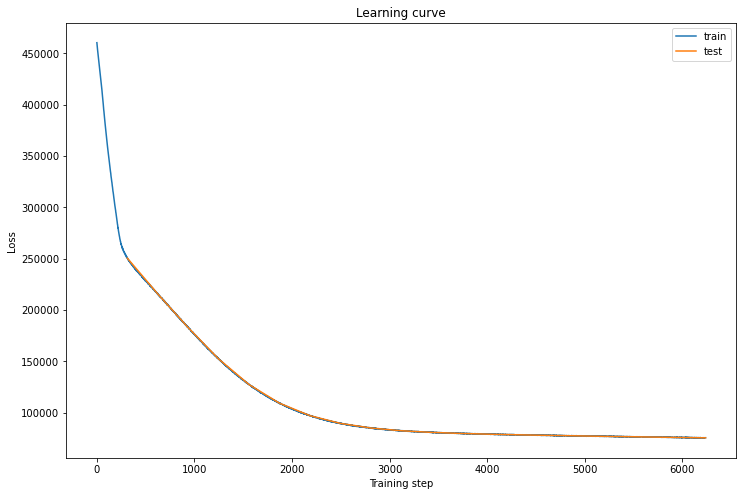

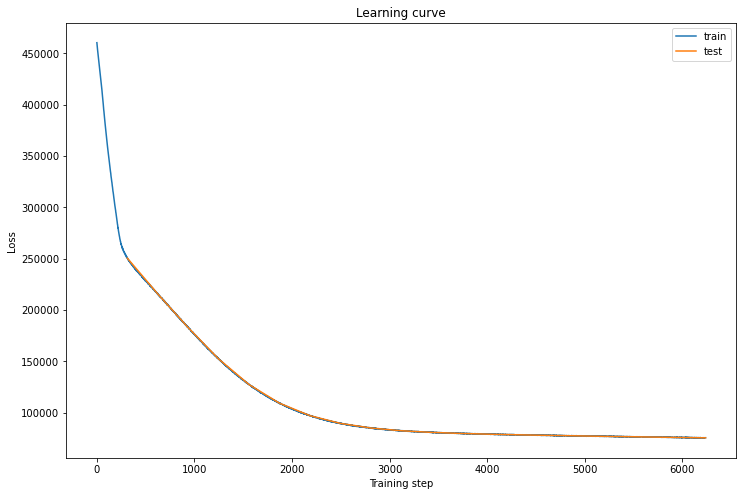

In [10]:
utils.show_learning_curve(train_metrics, test_metrics)

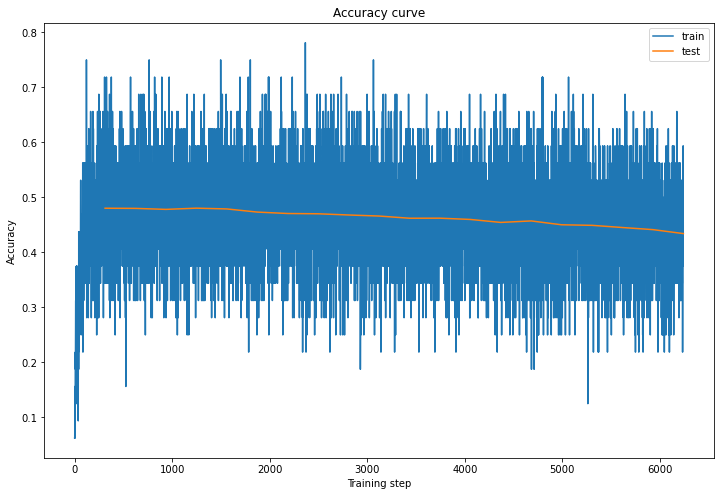

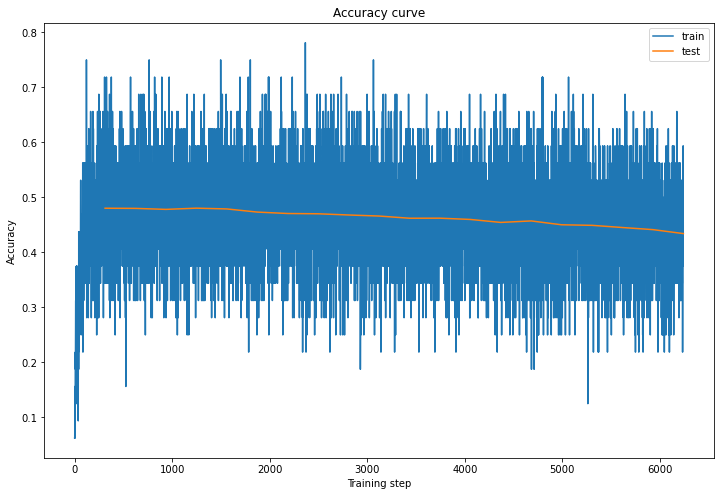

In [11]:
utils.show_accuracy_curve(train_metrics, test_metrics)

In [12]:
print(f"Best training accuracy: {max(train_metrics['acc'])}")
print(f"Best testing accuracy: {max(test_metrics['acc'])}")

Best training accuracy: 0.78125
Best testing accuracy: 0.4803999960422516


In [13]:
num_samplings = 10
analyzer = utils.Analyzer(model, test_dataset, num_samplings)

Top high confidence correct predictions


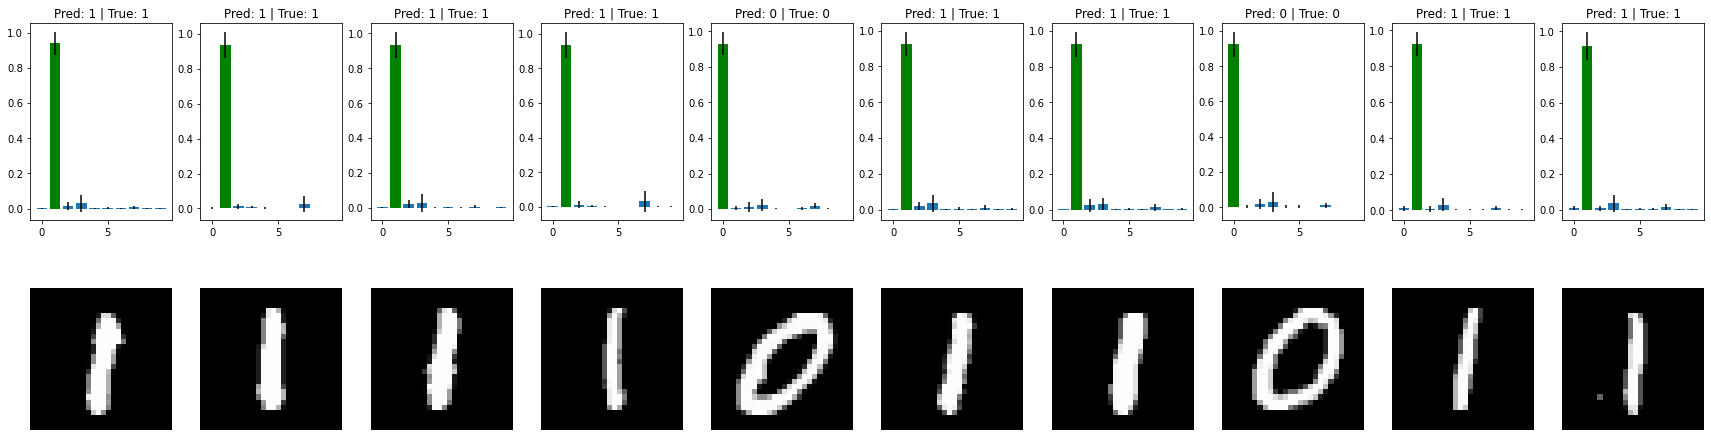

In [14]:
utils.visualize_samples(
    *analyzer.get_top_k_high_confidence_correct(10)
)
print("Top high confidence correct predictions")

Top low confidence correct predictions


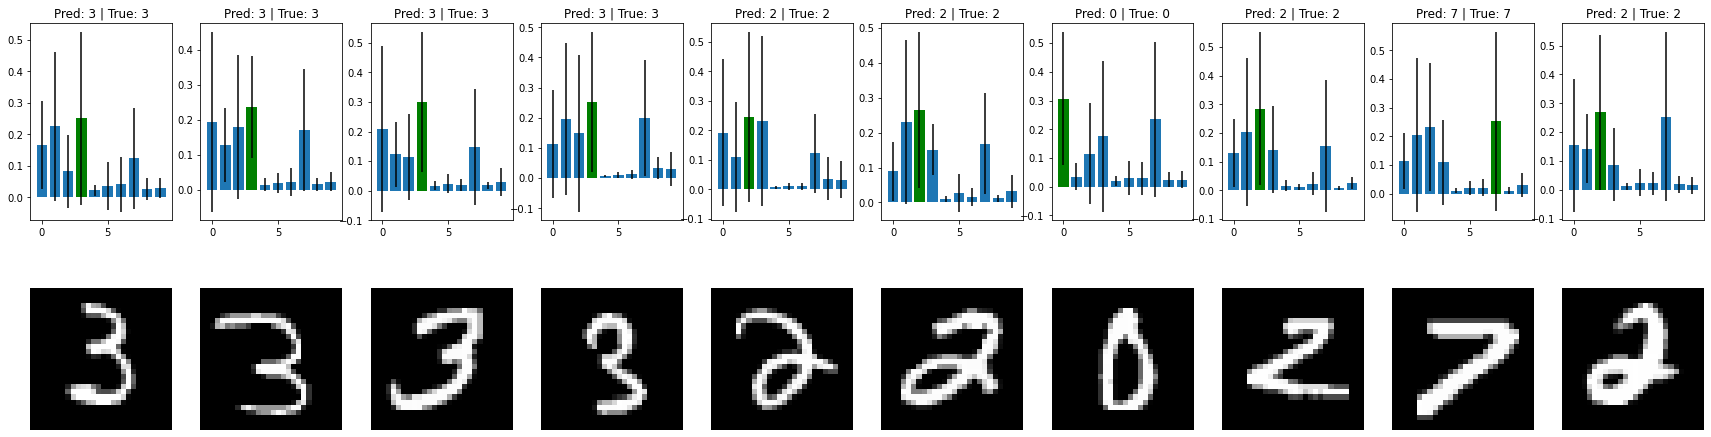

In [15]:
utils.visualize_samples(
    *analyzer.get_top_k_low_confidence_correct(10)
)
print("Top low confidence correct predictions")

Top low confidence wrong predictions


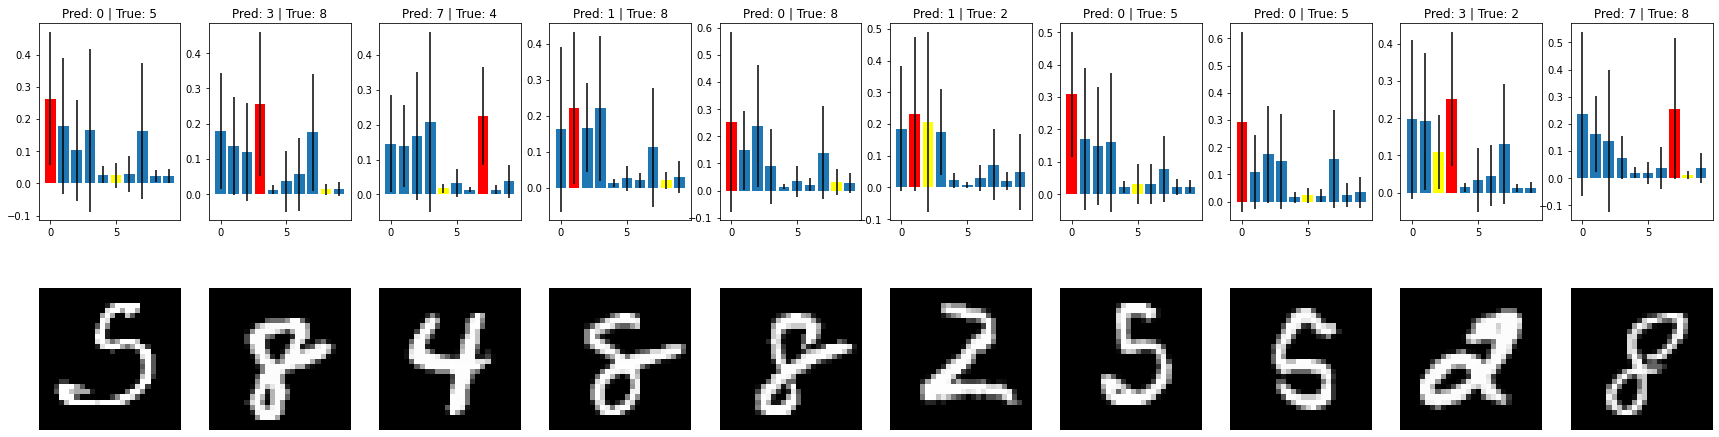

In [16]:
utils.visualize_samples(
    *analyzer.get_top_k_low_confidence_mistakes(10)
)

print("Top low confidence wrong predictions")

Top high confidence wrong predictions


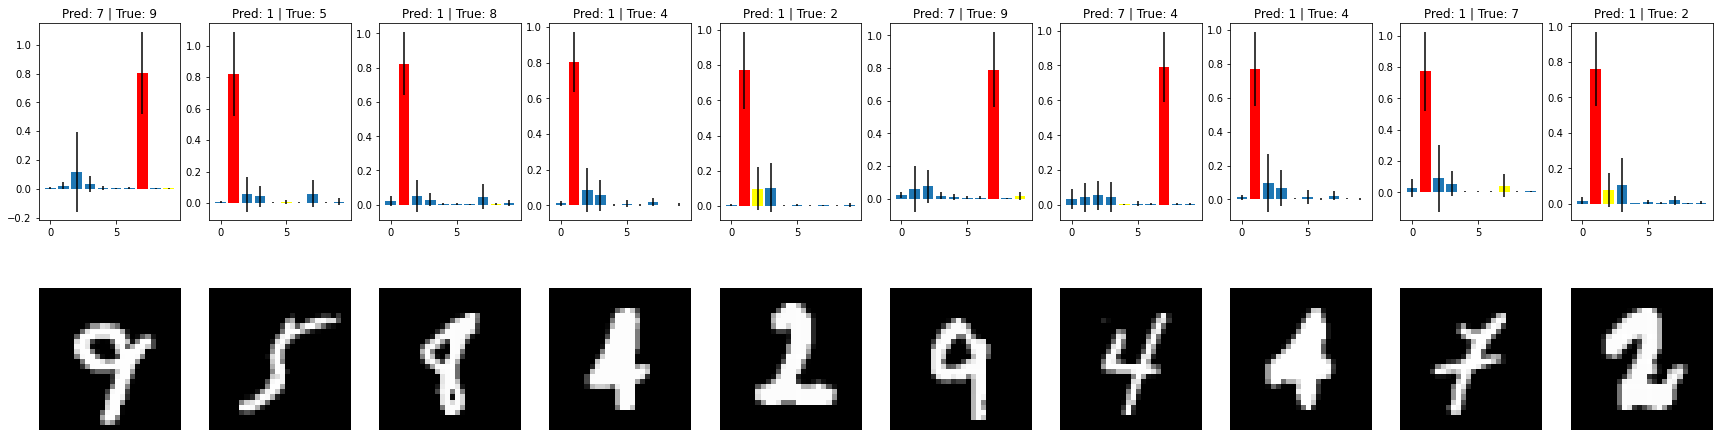

In [17]:
utils.visualize_samples(
    *analyzer.get_top_k_high_confidence_mistakes(10)
)

print("Top high confidence wrong predictions")

In [18]:
utils.visualize_weights(
    #TODO: get tensor of the first layer to the hidden layer weights in your model, 
    "layer input -> hidden"
)
print("Histogram of weights for layer 1")

TypeError: visualize_weights() missing 1 required positional argument: 'name'

In [ ]:
utils.visualize_weights(
    #TODO: get tensor of the second layer to the output layer weights in your model, 
    "layer hidden -> output"
)
print("Histogram of weights for layer 2")

In [ ]:
torch.rand((100,2))

In [ ]:

x = [torch.tensor([[0.0811, 0.1170, 0.0819, 0.0592, 0.0194, 0.0567, 0.2135, 0.0637, 0.0984,
         0.2090]])]

In [ ]:
x

In [ ]:
y = torch.stack(x,dim=-1)

In [ ]:
y.size()